Importing packages for face recognition

In [1]:
import os,sys
import matplotlib.pyplot as plt
import cv2
import pickle
from imutils import paths
from sklearn.cluster import KMeans

Defining functions for face detection and recognition

In [2]:
def face_detection(frame):
    # net = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
    
    cols = frame.shape[1]
    rows = frame.shape[0]
    MAX_WIDTH = 1024
    scale = 1   
    if (cols > MAX_WIDTH):
        scale = MAX_WIDTH * 1.0 / cols
        _frame = cv2.resize(frame, (MAX_WIDTH, int(scale * rows)))
    else:
        _frame = frame
    
    rows, cols = _frame.shape[:2]

    rect = []
    for alpha in range(10, 15, 1):
        alpha = alpha/10.0
        for beta in range(0, 11, 10):
            frame = _frame.copy()
            frame = brightness_contrast(frame, alpha, -beta * 10 * (alpha - 1))
            net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (104.0, 177.0, 123.0), False, False))
            detections = net.forward()
            for i in range(detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > confThreshold:
                    x1 = int(detections[0, 0, i, 3] * cols)
                    y1 = int(detections[0, 0, i, 4] * rows)
                    x2 = int(detections[0, 0, i, 5] * cols)
                    y2 = int(detections[0, 0, i, 6] * rows)
                    
                    rect.append([x1,y1,x2,y2])
            if len(rect) != 0:
                return _frame, rect
            
    return _frame, rect

def brightness_contrast(image, alpha, beta):
    rstimg = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return rstimg

def face_recognition_sift(face_image, svm_model):
    gray = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
    
    kp1, des1 = sift.detectAndCompute(face_image,None)

    kmeans = KMeans(n_clusters=1, random_state=0).fit(des1)

    sift_feature = kmeans.cluster_centers_

    sift_face_image = cv2.drawKeypoints(gray, kp1, face_image)

    sift_face_image = cv2.resize(sift_face_image, (224, 224))

    name = svm_model.predict(sift_feature)[0]

    return name, sift_face_image


Import face detection model and recognition model

In [3]:
modelFile = "model/det_uint8.pb"
configFile = "model/det.pbtxt"

net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

inWidth = 300
inHeight = 300
confThreshold = 0.9

# load face recognition SVM model
Pkl_Filename = "sift-svm-0.6739.pkl"

with open(Pkl_Filename, 'rb') as file:  
    svm_model = pickle.load(file)
print(svm_model)


# load SIFT feature extraction
sift = cv2.xfeatures2d.SIFT_create()

# target names
target_names = ['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair']

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


Train/Test and save the model

George W Bush


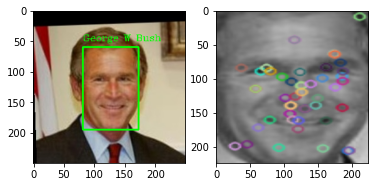

In [4]:
imagePath = 'D:\\George_W_Bush_0043.jpg'
image = cv2.imread(imagePath)

h, w, _ = image.shape

result = ''
if image is not None:
    imgname = os.path.basename(imagePath)
    dirpath = os.path.dirname(imagePath)
    last_dirname = dirpath.split('\\')[-1]
    name = imgname.split('.')[0]
    save_name = last_dirname + '_' + name
    resized_img, face_rect = face_detection(image)

    temp_img = resized_img.copy()

    real_face_count = 0


    if len(face_rect) != 0:
        face_count = 0
        for i in range(len(face_rect)):

            x1 = face_rect[i][0]
            y1 = face_rect[i][1]
            x2 = face_rect[i][2]
            y2 = face_rect[i][3]

            face_img = resized_img[y1:y2, x1:x2]

            predict_name, feature_face = face_recognition_sift(face_img, svm_model)

            predict_name = target_names[predict_name]
            print(predict_name)

            cv2.rectangle(temp_img,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(temp_img, predict_name, (x1,y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB) 

#             cv2.imshow('image', temp_img)
#             cv2.imshow('SIFT features', feature_face)
#             cv2.waitKey(0)
            fig=plt.figure()
            fig.add_subplot(1,2,1)
            plt.imshow(temp_img)
            fig.add_subplot(1,2,2)
            plt.imshow(feature_face)
            plt.show()


    else:
        plt.imshow(image)
        plt.show()
